# Credit Risk Project

First and foremost the goal is to learn about credit risk and applying machine learning and analysis.

We need a data set to work with. I am going to look on Kaggle.

Before starting, I am going to lay out some stuff I know about credit risk and how machine learning applies. First credit risk is quantifying or decidimg how risky it is to loan out money to a person or organization based on the information on their application. Some ML algorithms that would be useful would be supervised learning to help the algorithm make decisions on whether to give a loan to someone based on their labels of past successful or unsuccessful algorithms. ML algorithms that work well with tabular data like XGBoost or Random Forest would be good for this situation. Unsupervised algorithms would be use in order to group applications into certain categories without specifically specifying their labels. They would be group on how similar they are to other. Classification algorithms are the way to go on this one (I think... I haven't seen the data). Specifically Logistical Classification helps with probability of a grant or maybe even supper vector machines that could split the accepted vs unaccepted applications. Knowing all this so far let's do some EDA and figure it out from there. 

In [10]:
import kagglehub

# Download latest versionc:\Users\ty725\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3
path = kagglehub.dataset_download("wordsforthewise/lending-club")

print("Path to dataset files:", path)

100%|██████████| 1.26G/1.26G [00:20<00:00, 67.4MB/s]

Extracting files...


Path to dataset files: C:\Users\ty725\.cache\kagglehub\datasets\wordsforthewise\lending-club\versions\3


In [3]:
path = "C:\\Users\\ty725\.cache\kagglehub\\datasets\wordsforthewise\\lending-club\\versions\\3"
path1 = path + "\\accepted_2007_to_2018q4.csv\\accepted_2007_to_2018Q4.csv"
path2 = path + "\\rejected_2007_to_2018q4.csv\\rejected_2007_to_2018Q4.csv"

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\ty725\AppData\Local\Temp\ipykernel_12772\25542923.py:1: SyntaxWarning: invalid escape sequence '\.'
  path = "C:\\Users\\ty725\.cache\kagglehub\\datasets\wordsforthewise\\lending-club\\versions\\3"


Okay these datasets are huge! I think this is a good oppurtunity to use PySpark. I heard that it works really well with huge datasets. 

## Dataset EDA

In [4]:
from pyspark.sql import SparkSession

# Start new session
spark = SparkSession.builder \
    .appName("NewSession") \
    .getOrCreate()

In [5]:
dfa = spark.read.csv(path1, header=True)

Ok so there's a one thing to notice other than the amount of rows being huge: the columns are very different for the rejected pile vs the accepted pile. The accepted pile includes way more information about the actual loan that give out as well. So before we start cleaning, we have to figure which of the most important features/columns we need to clean. The best way to do that is to figure out which of the columns match because the goal is to get the accepted and the reject in one pile for the ML algo. 

After some inspiration, I understand how I am supposed to approach this problem. Focus on only accepted loans to predict the probability of default among accepted loans. The key column here is the loan status, mainly between statuses "Charged Off" vs "Fully Paid".

Ok so the next step is to load it on to the cloud and query it so we can get a dirty dataset. We'll use PySpark to clean it on the occasion that the dataset is still huge.

In [6]:
dfa.createOrReplaceTempView('loans')

In [7]:
df = spark.sql('''
    SELECT * FROM loans
    WHERE loan_status = 'Charged Off' OR  loan_status = 'Fully Paid'
''')
df.show()

+--------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+--------+-----------+----------+--------------------+----+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+---------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+------------------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------+-------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-

In [8]:
#df.describe().show()

In [9]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [10]:
rows = df.count()
rows

1345309

In [11]:
from pyspark.sql.functions import col, isnull, sum

def nullCount(dft):
    nullCounts = dft.agg(*[
        ((sum(isnull(col(c)).cast('integer')) / rows) * 100).alias(c)
        for c in dft.columns
    ])
    nullCounts.show()

nullCount(df)

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+-----------------+-----------------+--------------+----------+-------------------+-------+-----------+----------+---+-----------------+-------+------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+-------------------+--------------------+-----------------+--------------------+--------------------+--------------------+--------------------------+---------------------------+--------------------+----------------

I know I keep saying this but this dataset really is huge. My first approach was to go through each of attributes, figure out what they mean, and then figure out if they are useful. The thing is there is 151 attributes and I don't have all night here. We can't have a lot of attributes because this can cause the model to overfit, the key is generalization for a good ML model. So instead of getting 151 attributes down to 20 or so, it's better to hand pick the key features we need for our model and then clean that.

In [12]:
features = '''
id, loan_status, loan_amnt, int_rate, installment, grade, sub_grade, emp_length,
home_ownership, annual_inc, verification_status, purpose, dti, delinq_2yrs, 
inq_last_6mths, fico_range_low, fico_range_high
'''

def cleanStrings(strings):
    strings = strings.split(',')
    for i, string in enumerate(strings):
        strings[i] = string.strip()
    return strings



In [13]:
features = cleanStrings(features)
df = df.select(features)

In [14]:
#df.toPandas()

## Data Cleaning 

In [15]:
df.show(5)

+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+
|      id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+
|68407277| Fully Paid|   3600.0|   13.99|     123.03|    C|       C4| 10+ years|      MORTGAGE|   55000.0|       Not Verified|debt_consolidation| 5.91|        0.0|           1.0|         675.0|          679.0|
|68355089| Fully Paid|  24700.0|   11.99|     820.28|    C|       C1| 10+ years|      MORTGAGE|   65000.0|       Not Verified|    small_business|16.06|        1

In [16]:
nullCount(df)

+---+-----------+---------+--------+-----------+-----+---------+-----------------+--------------+----------+-------------------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+
| id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|       emp_length|home_ownership|annual_inc|verification_status|purpose|                dti|         delinq_2yrs|      inq_last_6mths|      fico_range_low|     fico_range_high|
+---+-----------+---------+--------+-----------+-----+---------+-----------------+--------------+----------+-------------------+-------+-------------------+--------------------+--------------------+--------------------+--------------------+
|0.0|        0.0|      0.0|     0.0|        0.0|  0.0|      0.0|5.835908330353845|           0.0|       0.0|                0.0|    0.0|0.02787463697931107|7.433236527816287E-5|1.486647305563257...|7.433236527816287E-5|7.433236527816287E-5|
+---+-----------+---------+--------+

Ok all missing values seems to be under 6% so it safe to drop all the rows that have a missing values. This saves a massive headache. Now there is something to note. Looking at the data, I assumed that if they're missing employment length, then that must mean that they're unemployed. Using data wrangler, some people have job titles but no employment length, so the unemployment assumption is not always valid. This is kind of significant to note becase employment length has the highest null count of 6%, everything else is less significant. Any ways, we'll drop any rows with missing cells, this dataset is huge.

In [17]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- fico_range_low: string (nullable = true)
 |-- fico_range_high: string (nullable = true)



In [18]:
colsFloats ='loan_amnt, int_rate, installment, annual_inc, dti'
colsInts = 'delinq_2yrs, fico_range_low, fico_range_high, inq_last_6mths'

colsFloats = cleanStrings(colsFloats)
colsInts = cleanStrings(colsInts)

for column in colsFloats:
    df = df.withColumn(column, col(column).cast('float'))

for column in colsInts:
    df = df.withColumn(column, col(column).cast('int'))

In [19]:
df = df.na.drop()
rows = df.count()
nullCount(df)

+---+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+---+-----------+--------------+--------------+---------------+
| id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|purpose|dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+---+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+---+-----------+--------------+--------------+---------------+
|0.0|        0.0|      0.0|     0.0|        0.0|  0.0|      0.0|       0.0|           0.0|       0.0|                0.0|    0.0|0.0|        0.0|           0.0|           0.0|            0.0|
+---+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+-------+---+-----------+--------------+--------------+---------------+



In [20]:
rows = df.count()
rows

1266557

In [21]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- loan_amnt: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- fico_range_low: integer (nullable = true)
 |-- fico_range_high: integer (nullable = true)



Ok so we're going to try something. We're going to apply One Hot Encoder becase we have some attributes that cannot be easily converted clean numbers for the algo to understand. One Hot Encoder is good for categorical data, namely in this case: loan_status, grade, sub_grade, emp_length (maybe, there's still hope for this one), home_ownership, verification_status, and purpose.

In [22]:
df = df.filter(col('home_ownership') != 'ANY')

In [23]:
otherInfo = df.filter(col('home_ownership') == 'OTHER').groupBy('loan_status').count()
otherInfo

DataFrame[loan_status: string, count: bigint]

In [24]:
NoneInfo =  df.filter(col('home_ownership') == 'NONE').groupBy('loan_status').count()
NoneInfo

DataFrame[loan_status: string, count: bigint]

In [25]:
from pyspark.sql.functions import when, col
common_owners = ["RENT", "OWN", "MORTGAGE"]

df = df.withColumn(
    "home_ownership",
    when(col("home_ownership").isin(common_owners), col("home_ownership"))
    .otherwise("OTHER")
)

In [26]:
encodedCols = 'loan_status, emp_length, home_ownership, verification_status, purpose'
encodedCols = cleanStrings(encodedCols)
encodedCols

['loan_status',
 'emp_length',
 'home_ownership',
 'verification_status',
 'purpose']

In [27]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
from pyspark.ml import Pipeline

stages = []
for c in encodedCols:
    indexer = StringIndexer(inputCol = c, outputCol = c + '_')
    encoder = OneHotEncoder(inputCol = c + '_', outputCol = c + '-', dropLast = True)
    stages += [indexer, encoder]

pipeline = Pipeline(stages=stages)
encoded_df = pipeline.fit(df).transform(df)

In [28]:
encoded_df.show(5)

+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+------------+-------------+-----------+--------------+---------------+---------------+--------------------+--------------------+--------+--------------+
|      id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|loan_status_| loan_status-|emp_length_|   emp_length-|home_ownership_|home_ownership-|verification_status_|verification_status-|purpose_|      purpose-|
+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+------------+-------------+-----------+--------------+-------------

In [29]:
empInfo = encoded_df.groupBy("emp_length").count()
empInfo

DataFrame[emp_length: string, count: bigint]

In [30]:
empLoanInfo = encoded_df.groupBy("emp_length", "loan_status").count()
empLoanInfo

DataFrame[emp_length: string, loan_status: string, count: bigint]

In [31]:
import pandas as pd
empLoanInfo = empLoanInfo.toPandas()

In [32]:
def pivotIt(dft, index):
    pivot = dft.pivot_table(index = index, columns = "loan_status", values = "count", aggfunc = "sum")
    pivot['total'] = pivot.loc[:, 'Charged Off'] + pivot.loc[:, 'Fully Paid']
    pivot['default_percentage'] = (pivot.loc[:, 'Charged Off'] / pivot['total']) * 100
    return pivot.sort_values(ascending = True, by = 'default_percentage')

In [33]:
pivotIt(empLoanInfo, "emp_length")

loan_status,Charged Off,Fully Paid,total,default_percentage
emp_length,,,,
10+ years,83037,359045,442082,18.783167
6 years,12137,50571,62708,19.354787
7 years,11615,47989,59604,19.486947
5 years,16485,67621,84106,19.600266
4 years,15892,64615,80507,19.739898
2 years,24102,97588,121690,19.806065
9 years,10135,40786,50921,19.903380
8 years,12098,48591,60689,19.934420
3 years,21478,86065,107543,19.971546


With emp_length, after some data analysis I found that the difference is between 10+ and <1 is 1.75% (with 10+ having a lower charged off percentage), but the range between all the other numbers (2-9) was 0.6% and they were pretty random in order. Based on my findings I think I should use One Hot Encoding because the linear progression at least for the middle numbers is none existent. For the remaining columns (grade and subgrade) needs to be encoded in ordinally which basically means that the order matters when encoding. 

In [34]:
grade_df = encoded_df.groupBy("grade", "loan_status").count().toPandas()
pivotIt(grade_df, "grade")

loan_status,Charged Off,Fully Paid,total,default_percentage
grade,,,,
A,12790,209530,222320,5.752969
B,47954,321888,369842,12.966077
C,78808,280035,358843,21.961694
D,56194,131782,187976,29.894242
E,33675,54570,88245,38.160802
F,13619,16764,30383,44.824408
G,4300,4381,8681,49.533464


In [35]:
subgrade_df = encoded_df.groupBy("sub_grade", "loan_status").count().toPandas()
pivotIt(subgrade_df, "sub_grade")

loan_status,Charged Off,Fully Paid,total,default_percentage
sub_grade,,,,
A1,1242,39975,41217,3.013320
A2,1532,33576,35108,4.363678
A3,1850,34059,35909,5.151912
A4,3237,46082,49319,6.563393
A5,4929,55838,60767,8.111310
B1,6695,60318,67013,9.990599
B2,7635,62017,69652,10.961638
B3,9711,67472,77183,12.581786
B4,11316,67136,78452,14.424106


This confirms the decision for Ordinal Encoding.

In [36]:
grades = ['A', 'B', 'C', 'D', 'E', 'F', 'G']
levels = [1,2,3,4,5]
submap = {}
k = 0
ran = len(grades) * len(levels)
for i in range(len(grades)):
    for j in range(len(levels)):
        submap[grades[i] + str(levels[j])] = k
        k += 1
        
map = {}
for i in range(len(grades)):
    map[grades[i]] = i

In [37]:
from pyspark.sql.functions import lit
encoded_df = encoded_df.withColumn('sub_grade-', lit(None))
encoded_df = encoded_df.withColumn('grade-', lit(None))

for value, key in enumerate(map):
    encoded_df = encoded_df.withColumn('grade-', when(col("grade") == lit(key), value).otherwise(col("grade-")))

for value, key in enumerate(submap):
    encoded_df = encoded_df.withColumn('sub_grade-', when(col("sub_grade") == lit(key), value).otherwise(col("sub_grade-")))


In [38]:
encoded_df.show(5)

+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+------------+-------------+-----------+--------------+---------------+---------------+--------------------+--------------------+--------+--------------+----------+------+
|      id|loan_status|loan_amnt|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|           purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|loan_status_| loan_status-|emp_length_|   emp_length-|home_ownership_|home_ownership-|verification_status_|verification_status-|purpose_|      purpose-|sub_grade-|grade-|
+--------+-----------+---------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+------------------+-----+-----------+--------------+--------------+---------------+------------+-------------+----

In [39]:
col_names = '''id, loan_status-, loan_amnt, int_rate, installment, grade-, sub_grade-, 
emp_length-, home_ownership-, annual_inc, verification_status-, purpose-, dti, 
delinq_2yrs, inq_last_6mths, fico_range_low, fico_range_high
'''
col_names = cleanStrings(col_names)
df = encoded_df.select(col_names)
df.show(5)

+--------+-------------+---------+--------+-----------+------+----------+--------------+---------------+----------+--------------------+--------------+-----+-----------+--------------+--------------+---------------+
|      id| loan_status-|loan_amnt|int_rate|installment|grade-|sub_grade-|   emp_length-|home_ownership-|annual_inc|verification_status-|      purpose-|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+--------+-------------+---------+--------+-----------+------+----------+--------------+---------------+----------+--------------------+--------------+-----+-----------+--------------+--------------+---------------+
|68407277|(1,[0],[1.0])|   3600.0|   13.99|     123.03|     2|        13|(10,[0],[1.0])|  (3,[0],[1.0])|   55000.0|       (2,[1],[1.0])|(13,[0],[1.0])| 5.91|          0|             1|           675|            679|
|68355089|(1,[0],[1.0])|  24700.0|   11.99|     820.28|     2|        10|(10,[0],[1.0])|  (3,[0],[1.0])|   65000.0|       (2,[1],[1.0])|

In [40]:
for i in range(len(col_names)):
    df = df.withColumnRenamed(col_names[i], features[i])   

In [41]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- loan_status: vector (nullable = true)
 |-- loan_amnt: float (nullable = true)
 |-- int_rate: float (nullable = true)
 |-- installment: float (nullable = true)
 |-- grade: integer (nullable = true)
 |-- sub_grade: integer (nullable = true)
 |-- emp_length: vector (nullable = true)
 |-- home_ownership: vector (nullable = true)
 |-- annual_inc: float (nullable = true)
 |-- verification_status: vector (nullable = true)
 |-- purpose: vector (nullable = true)
 |-- dti: float (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- fico_range_low: integer (nullable = true)
 |-- fico_range_high: integer (nullable = true)



In [42]:
df.count()

1266290

In [43]:
df.show(5)

+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|      id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|68407277|(1,[0],[1.0])|   3600.0|   13.99|     123.03|    2|       13|(10,[0],[1.0])| (3,[0],[1.0])|   55000.0|      (2,[1],[1.0])|(13,[0],[1.0])| 5.91|          0|             1|           675|            679|
|68355089|(1,[0],[1.0])|  24700.0|   11.99|     820.28|    2|       10|(10,[0],[1.0])| (3,[0],[1.0])|   65000.0|      (2,[1],[1.0])|(13,[5],[1.0])|16.06

In [44]:
df.sort(col("delinq_2yrs").desc()).show(5)

+---------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|       id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+---------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
| 46305428|(1,[0],[1.0])|  12500.0|   17.57|     314.51|    3|       18|(10,[0],[1.0])| (3,[1],[1.0])|   25000.0|      (2,[1],[1.0])|(13,[3],[1.0])|32.69|         39|             1|           665|            669|
| 65373706|(1,[0],[1.0])|  15000.0|   13.67|     510.27|    2|       13|(10,[2],[1.0])| (3,[1],[1.0])|  140000.0|      (2,[0],[1.0])|(13,[3],[1.0])|

In [45]:
df.sort("loan_amnt").show(5)

+------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|    id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|242695|(1,[0],[1.0])|    500.0|   10.71|      16.31|    1|        9|(10,[2],[1.0])| (3,[0],[1.0])|   7904.04|      (2,[1],[1.0])|(13,[9],[1.0])| 3.04|          1|             2|           680|            684|
|164346|(1,[0],[1.0])|    500.0|    8.07|      15.69|    0|        3|(10,[2],[1.0])| (3,[1],[1.0])|   18000.0|      (2,[1],[1.0])|(13,[3],[1.0])| 4.27|         

Ok almost everything seems to be in order. I need one extra check to make sure the data is clean. Next I'm going to handle outliers, logical consistencies, and known ranges. 

In [46]:
df.filter(col('fico_range_low') > col('fico_range_high')).count()

0

In [47]:
df.createOrReplaceTempView('cleanDataset')

In [48]:
query = spark.sql('''
SELECT * FROM cleanDataset
WHERE (fico_range_low < 300 OR fico_range_low > 850)
                  OR (fico_range_high < 300 OR fico_range_high > 850)
''')
query.count()

0

In [49]:
query = spark.sql('''SELECT * FROM cleanDataset
                  WHERE loan_amnt < 0
''')
query.count()

0

I checked manually for negative values and max loan amount using the sort function for each column (that's numbered anyway). Now time to handle outline.

In [50]:
def printQuantiles(column):
    quant = df.approxQuantile(column, probabilities = [0.25, 0.75], relativeError = 0)
    IQR = quant[1] - quant[0]
    lower = quant[0] - 1.5 * IQR
    upper = quant[1] + 1.5 * IQR
    print(column)
    print(f'Lower : {lower}')
    print(f'Upper : {upper}')
    print(f'IQR : {IQR}')

In [51]:
#for feature in colsInts:
    #printQuantiles(feature)


In [52]:
#for feature in colsFloats:
    #printQuantiles(feature)

Ok so looking through all the information there is no one size fits all appraoch, you'd have to do deep analysis of each feature to figure out the best appraoch. Now, in general I'm going use a general approach of capping outliers to a certain value. I'm doing this because extreme values are legit but could be too influential during model training. 

In [53]:
capVals = {"loan_amnt" : 35000, "int_rate" : 30, "installment" : 1100,
           "annual_inc" : 250000, "dti" : 45, "delinq_2yrs" : 4, 
           "inq_last_6mths" : 6}

In [54]:
for key, values in capVals.items():
    df = df.withColumn(key, when(col(key) > values,  values).otherwise(col(key)))
    df = df.withColumn(key, when(col(key) < 0, 0).otherwise(col(key)))
df.show(10)

+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|      id|  loan_status|loan_amnt|int_rate|installment|grade|sub_grade|    emp_length|home_ownership|annual_inc|verification_status|       purpose|  dti|delinq_2yrs|inq_last_6mths|fico_range_low|fico_range_high|
+--------+-------------+---------+--------+-----------+-----+---------+--------------+--------------+----------+-------------------+--------------+-----+-----------+--------------+--------------+---------------+
|68407277|(1,[0],[1.0])|   3600.0|   13.99|     123.03|    2|       13|(10,[0],[1.0])| (3,[0],[1.0])|   55000.0|      (2,[1],[1.0])|(13,[0],[1.0])| 5.91|          0|             1|           675|            679|
|68355089|(1,[0],[1.0])|  24700.0|   11.99|     820.28|    2|       10|(10,[0],[1.0])| (3,[0],[1.0])|   65000.0|      (2,[1],[1.0])|(13,[5],[1.0])|16.06

In [55]:
df.describe().show()

+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|summary|                  id|         loan_amnt|          int_rate|      installment|             grade|         sub_grade|       annual_inc|              dti|       delinq_2yrs|    inq_last_6mths|   fico_range_low|  fico_range_high|
+-------+--------------------+------------------+------------------+-----------------+------------------+------------------+-----------------+-----------------+------------------+------------------+-----------------+-----------------+
|  count|             1266290|           1266290|           1266290|          1266290|           1266290|           1266290|          1266290|          1266290|           1266290|           1266290|          1266290|          1266290|
|   mean|5.5883809025573134E7|14572.497808558861|13.23121003

In [56]:
from pyspark.ml.functions import vector_to_array
for feature in encodedCols:
    df = df.withColumn(feature, vector_to_array(col(feature)))

In [57]:
df.write.mode('overwrite').parquet("cleanLoans.parquet")

In [58]:
dataset = pd.read_parquet("cleanLoans.parquet")

In [59]:
dataset

,id,loan_status,loan_amnt,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,purpose,dti,delinq_2yrs,inq_last_6mths,fico_range_low,fico_range_high
0,68407277,[1.0],3600.0,13.990000,123.029999,2,13,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",55000.0,"[0.0, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.910000,0,1,675,679
1,68355089,[1.0],24700.0,11.990000,820.280029,2,10,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",65000.0,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",16.059999,1,4,715,719
2,68341763,[1.0],20000.0,10.780000,432.660004,1,8,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",63000.0,"[0.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.780000,0,0,695,699
3,68476807,[1.0],10400.0,22.450001,289.910004,5,25,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",104433.0,"[1.0, 0.0]","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",25.370001,1,3,695,699
4,68426831,[1.0],11950.0,13.440000,405.179993,2,12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]",34000.0,"[1.0, 0.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.200000,0,0,690,694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266285,89905081,[1.0],18000.0,9.490000,377.950012,1,6,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 1.0]",130000.0,"[0.0, 1.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",20.590000,0,1,735,739
1266286,88948836,[1.0],29400.0,13.990000,683.940002,2,12,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",180792.0,"[0.0, 1.0]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",22.030001,0,1,705,709
1266287,89996426,[0.0],32000.0,14.490000,752.739990,2,13,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 0.0, 0.0]",157000.0,"[1.0, 0.0]","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",10.340000,0,0,735,739
1266288,90006534,[1.0],16000.0,12.790000,362.339996,2,10,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 1.0, 0.0]",150000.0,"[0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",12.250000,0,0,665,669


In [60]:
def expandColumn(dataset, colName):
    columns = []
    for i in range(len(dataset[colName][0])):
        columns.append(f"{colName}_{i}")
    arr = pd.DataFrame(dataset[colName].tolist(), columns = columns)
    dataset = dataset.drop(columns = [colName])
    return pd.concat([dataset, arr], axis = 1)

In [61]:
df = dataset
for feature in encodedCols:
    df = expandColumn(df, feature)

In [62]:
df.drop(axis = 1, columns = ['id'], inplace = True)


In [63]:
df

,loan_amnt,int_rate,installment,grade,sub_grade,annual_inc,dti,delinq_2yrs,inq_last_6mths,fico_range_low,...,purpose_3,purpose_4,purpose_5,purpose_6,purpose_7,purpose_8,purpose_9,purpose_10,purpose_11,purpose_12
0,3600.0,13.990000,123.029999,2,13,55000.0,5.910000,0,1,675,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,24700.0,11.990000,820.280029,2,10,65000.0,16.059999,1,4,715,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,20000.0,10.780000,432.660004,1,8,63000.0,10.780000,0,0,695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,10400.0,22.450001,289.910004,5,25,104433.0,25.370001,1,3,695,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11950.0,13.440000,405.179993,2,12,34000.0,10.200000,0,0,690,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1266285,18000.0,9.490000,377.950012,1,6,130000.0,20.590000,0,1,735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266286,29400.0,13.990000,683.940002,2,12,180792.0,22.030001,0,1,705,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266287,32000.0,14.490000,752.739990,2,13,157000.0,10.340000,0,0,735,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1266288,16000.0,12.790000,362.339996,2,10,150000.0,12.250000,0,0,665,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Building 

In [64]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [65]:
X = df.drop(columns = ['loan_status_0']).to_numpy()
Y = df['loan_status_0'].to_numpy()

In [66]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size = 0.2,  
                                                    random_state = 42, stratify = Y)

In [67]:
scaler = StandardScaler()
xTrainS = scaler.fit_transform(xTrain)
xTestS = scaler.transform(xTest)

In [68]:
model = LogisticRegression(max_iter = 1000, class_weight = 'balanced')
model.fit(xTrainS, yTrain)

LogisticRegression(class_weight='balanced', max_iter=1000)

In [69]:
yPred = model.predict(xTestS)
yProb = model.predict_proba(xTestS)[:, 0]

In [70]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

         0.0       0.31      0.64      0.42     49468
         1.0       0.88      0.66      0.75    203790

    accuracy                           0.65    253258
   macro avg       0.60      0.65      0.59    253258
weighted avg       0.77      0.65      0.69    253258



In [71]:
print(f'ROC AUC Score: {roc_auc_score(yTest, yProb)}')

ROC AUC Score: 0.2918692051096269


In [72]:
probs = pd.DataFrame(yProb, columns = ["Probability of Default"])
probs = probs * 100
probs

,Probability of Default
0,41.356410
1,74.934009
2,57.564146
3,22.698779
4,34.894455
...,...
253253,61.384023
253254,77.606112
253255,51.740594
253256,51.581501


In [73]:
# Fully Paid = 1 and Charged Off = 0
pred = pd.DataFrame(yPred, columns = ['Prediction'])
pred

,Prediction
0,1.0
1,0.0
2,0.0
3,1.0
4,1.0
...,...
253253,0.0
253254,0.0
253255,0.0
253256,0.0


In [74]:
# Fully Paid = 1 and Charged Off = 0
test = pd.DataFrame(yTest, columns = ['Real Values'])
test

,Real Values
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0
...,...
253253,1.0
253254,0.0
253255,0.0
253256,1.0


In [75]:
results = pd.concat([probs, pred, test], axis = 1)
results

,Probability of Default,Prediction,Real Values
0,41.356410,1.0,1.0
1,74.934009,0.0,1.0
2,57.564146,0.0,1.0
3,22.698779,1.0,1.0
4,34.894455,1.0,1.0
...,...,...,...
253253,61.384023,0.0,1.0
253254,77.606112,0.0,0.0
253255,51.740594,0.0,0.0
253256,51.581501,0.0,1.0


In [76]:
from sqlalchemy import create_engine 
server = 'dahomey.database.windows.net'
database = 'Stock Data'
username = 'ttshiamala'
password = 'Bear8486!?'
driver = '{ODBC Driver 18 for SQL Server}'

conn_url = f'mssql+pyodbc://{username}:{password}@{server}/{database}?driver=ODBC+Driver+18+for+SQL+Server'
engine = create_engine(conn_url)
try:
    results.to_sql(name="LoanPredictions", con=engine, if_exists="replace", index=False)
except Exception as e:
    results.to_sql(name="LoanPredictions", con=engine, if_exists="replace", index=False)

In [77]:
resultsPT = results.groupby(['Prediction', 'Real Values']).count()
resultsPT = resultsPT.rename(columns={'Probability of Default': 'Count'})
resultsPT

Count
Prediction Real Values        
0.0        0.0           31871
           1.0           69876
1.0        0.0           17597
           1.0          133914

# LGD

In [78]:
from pyspark.sql import SparkSession

# Start new session
spark = SparkSession.builder \
    .appName("NewSession") \
    .getOrCreate()

In [144]:
df = spark.sql('''
SELECT l.total_pymnt, cd.loan_amnt, cd.int_rate, cd.annual_inc, 
               cd.dti, cd.purpose, cd.fico_range_low, cd.emp_length, cd.grade
FROM loans AS l
JOIN cleanDataset AS cd ON cd.id = l.id
WHERE l.loan_status = 'Charged Off'

''')
df.show(5)

+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|total_pymnt|loan_amnt|int_rate|annual_inc|  dti|       purpose|fico_range_low|    emp_length|grade|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|    11632.9|  32200.0|   14.99|   94930.0|16.69|(13,[0],[1.0])|           685|(10,[0],[1.0])|    2|
|    8082.94|  25000.0|   13.49|   98700.0|26.48|(13,[0],[1.0])|           760|(10,[0],[1.0])|    2|
|     4379.7|   8000.0|   17.99|   60880.0|24.94|(13,[0],[1.0])|           730|(10,[0],[1.0])|    3|
|     8283.6|  14000.0|   14.99|   62000.0|24.74|(13,[3],[1.0])|           675|(10,[9],[1.0])|    2|
|    4545.37|  12000.0|   13.99|   95000.0|19.42|(13,[1],[1.0])|           690|(10,[1],[1.0])|    2|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
only showing top 5 rows



In [145]:
from pyspark.sql.functions import col
df = df.withColumn('total_pymnt', col('total_pymnt').astype('float'))
df = df.na.drop()
df.show(5)

+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|total_pymnt|loan_amnt|int_rate|annual_inc|  dti|       purpose|fico_range_low|    emp_length|grade|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
|    11632.9|  32200.0|   14.99|   94930.0|16.69|(13,[0],[1.0])|           685|(10,[0],[1.0])|    2|
|    8082.94|  25000.0|   13.49|   98700.0|26.48|(13,[0],[1.0])|           760|(10,[0],[1.0])|    2|
|     4379.7|   8000.0|   17.99|   60880.0|24.94|(13,[0],[1.0])|           730|(10,[0],[1.0])|    3|
|     8283.6|  14000.0|   14.99|   62000.0|24.74|(13,[3],[1.0])|           675|(10,[9],[1.0])|    2|
|    4545.37|  12000.0|   13.99|   95000.0|19.42|(13,[1],[1.0])|           690|(10,[1],[1.0])|    2|
+-----------+---------+--------+----------+-----+--------------+--------------+--------------+-----+
only showing top 5 rows



In [146]:
df = df.withColumnRenamed('loan_amnt', 'EAD')
df = df.withColumnRenamed('total_pymnt', 'Recovery')

In [147]:
from pyspark.ml.functions import vector_to_array
cols = ['purpose', 'emp_length']
for feature in cols:
    df = df.withColumn(feature, vector_to_array(col(feature)))

In [148]:
df = df.toPandas()
df

,Recovery,EAD,int_rate,annual_inc,dti,purpose,fico_range_low,emp_length,grade
0,11632.900391,32200.0,14.99,94930.0,16.690001,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",685,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
1,8082.939941,25000.0,13.49,98700.0,26.480000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",760,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
2,4379.700195,8000.0,17.99,60880.0,24.940001,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",730,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
3,8283.599609,14000.0,14.99,62000.0,24.740000,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",675,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
4,4545.370117,12000.0,13.99,95000.0,19.420000,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",690,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
...,...,...,...,...,...,...,...,...,...
247335,16976.050781,32000.0,13.49,75000.0,19.980000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",660,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
247336,367.329987,2750.0,12.74,14500.0,32.779999,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",675,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2
247337,2646.219971,6000.0,17.99,29580.0,16.059999,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",675,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3
247338,9046.179688,35000.0,13.99,125000.0,3.960000,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",670,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",2


In [149]:
df['LGD'] = ((df['EAD'] - df['Recovery']) / df['EAD']) 

In [150]:
df = expandColumn(df, 'purpose')
df = expandColumn(df, 'emp_length')

In [151]:
df = df.drop(axis = 1, columns = ['Recovery'])
df

,EAD,int_rate,annual_inc,dti,fico_range_low,grade,LGD,purpose_0,purpose_1,purpose_2,...,emp_length_0,emp_length_1,emp_length_2,emp_length_3,emp_length_4,emp_length_5,emp_length_6,emp_length_7,emp_length_8,emp_length_9
0,32200.0,14.99,94930.0,16.690001,685,2,0.638730,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,25000.0,13.49,98700.0,26.480000,760,2,0.676682,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8000.0,17.99,60880.0,24.940001,730,3,0.452537,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14000.0,14.99,62000.0,24.740000,675,2,0.408314,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,12000.0,13.99,95000.0,19.420000,690,2,0.621219,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247335,32000.0,13.49,75000.0,19.980000,660,2,0.469498,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
247336,2750.0,12.74,14500.0,32.779999,675,2,0.866425,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247337,6000.0,17.99,29580.0,16.059999,675,3,0.558963,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247338,35000.0,13.99,125000.0,3.960000,670,2,0.741538,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [152]:
capVals = {"EAD" : 35000, "int_rate" : 30, "LGD" : 100, 
           "annual_inc" : 250000, "dti" : 45}

In [153]:
for key, value in capVals.items():
    df[key] = df[key].clip(lower = 0, upper = value)

In [154]:
X = df.drop(axis = 1, columns = ['LGD', 'EAD'])
Y = df['LGD'] / 100

In [155]:
X = X.to_numpy()
Y = Y.to_numpy()

In [156]:
xTrain, xTest, yTrain, yTest = train_test_split(X, Y, test_size  = 0.2, random_state = 42)

In [157]:
scaler = StandardScaler()
xTrainS = scaler.fit_transform(xTrain)
xTestS = scaler.transform(xTest)

In [158]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(xTrainS, yTrain)

LinearRegression()

In [159]:
yPred = model.predict(xTestS)

In [165]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(yTest, yPred)
rmse = np.sqrt(mse)
r2 = r2_score(yTest, yPred)
mae = mean_absolute_error(yTest, yPred)

In [167]:
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

RMSE: 0.0026
MAE: 0.0022
R²: 0.0286


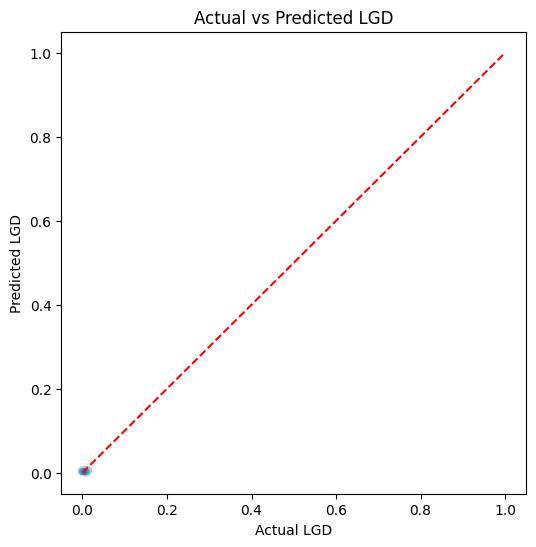

In [168]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 6))
sns.scatterplot(x=yTest, y=yPred, alpha=0.3)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # y = x line
plt.xlabel('Actual LGD')
plt.ylabel('Predicted LGD')
plt.title('Actual vs Predicted LGD')
plt.show()
